# 04 - Adversarial Patches

Attacking images at the pixel level is somehow easy. But what is needed to create attacks in the real world?
In this laboratory, you will learn how to code or configure SecML Torch to create simple adversarial patches.
This notebook is an adaptation from the documentation of SecML Torch, accessible here: [https://secml-torch.readthedocs.io/en/latest/tutorials/08-patch-attacks-introduction.html](https://secml-torch.readthedocs.io/en/latest/tutorials/08-patch-attacks-introduction.html)

In [1]:
try:
    import secmlt
except ImportError:
   %pip install secml-torch[foolbox,adv_lib]

import torch
import torchvision.datasets
from torchvision.models import get_model
from secmlt.metrics.classification import Accuracy
from secmlt.models.pytorch.base_pytorch_nn import BasePytorchClassifier
from torch.utils.data import DataLoader, Subset, TensorDataset
import requests, io
from PIL import Image
import torchvision.transforms as T
import json
import matplotlib.pyplot as plt


from secmlt.adv.backends import Backends
from secmlt.adv.evasion.perturbation_models import LpPerturbationModels
from secmlt.adv.evasion.pgd import PGD
from secmlt.optimization.constraints import MaskConstraint

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.0 MB/s eta 0:00:00
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408195 sha256=c2eff39a7e1f6ba53de80939a5dae9ab4cd7eaecaa91a99da1b8d945bd465008
  Stored in directory: /root/.cache/pip/wheels/37/6c/38/64eeaa310e325aacda723e6df1f79ab5e9f31ba195264e04a8
Successfully built visdom


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

net = get_model("vit_b_16", weights="IMAGENET1K_V1")
device = "cpu"
net.to(device)

# Wrap the model with SecML-Torch's BasePytorchClassifier
clf = BasePytorchClassifier(net, preprocessing=T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)))

labels_url = (
    "https://raw.githubusercontent.com/"
    "anishathalye/imagenet-simple-labels/master/"
    "imagenet-simple-labels.json"
)
r = requests.get(labels_url)
imagenet_labels = json.loads(r.text)

img_url = "https://www.kimballstock.com/images/car-stock-photos/toyota-stock-photos.jpg"
r = requests.get(img_url)
img = Image.open(io.BytesIO(r.content)).convert("RGB")

transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ToTensor(),
])

img = transform(img).unsqueeze(0)
test_ds = TensorDataset(
    img,
    torch.tensor([imagenet_labels.index("sports car")])
    )
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:03<00:00, 88.5MB/s]


torch.Size([1, 3, 224, 224])


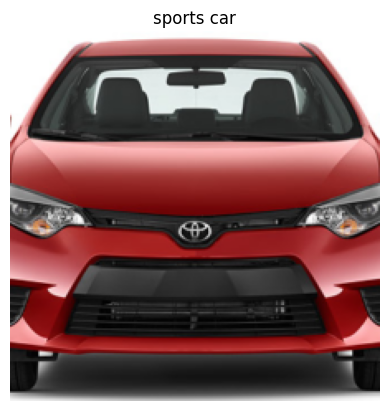

In [3]:
pred_label = imagenet_labels[clf.predict(img.to(device)).item()]
print(img.shape)
plt.imshow(img.squeeze().permute(1, 2, 0))
plt.title(pred_label)
plt.axis('off')
plt.show()

Given this pre-trained model on the [ImageNet dataset](https://www.image-net.org/), we want to compute an adversarial example that resembles a license plate, or a sticker placed somewhere on this car.
This can be achieved by modifying PGD in order to optimize the perturbation $\boldsymbol{\delta}$ only on a specific region, leaving 0 everywhere else.

This can be achieved in two equivalent ways:
* by setting zero all those entried of the gradients outside the mask
* by doing the same, but on $\boldsymbol{\delta}$

Let's have a look at a possible implementation.

In [20]:
def untargeted_l2_pgd_patch(model, x, y, location, epsilon=0.3, alpha=0.01, num_iter=40, lb=0, ub=1):
    delta = torch.zeros_like(x, requires_grad=True)
    # Clip the gradient to apply updates only on the patch location
    mask = torch.zeros_like(x)
    x_start, y_start, x_end, y_end = location
    mask[:, :, y_start:y_end, x_start:x_end] = 1.0
    for _ in range(num_iter):
        outputs = model(x + delta)
        loss = torch.nn.CrossEntropyLoss()(outputs, y)
        loss.backward()

        # Needed to avoid zero division during the normalization
        gradient = delta.grad.data / (delta.grad.data.norm() + 1e-10)
        gradient = gradient * mask # removing all the directions of the gradient except for the mask

        # Gradient ascent step
        delta.data = delta + alpha * gradient

        # Project the perturbation to be within the L2 ball of radius epsilon
        if delta.data.norm() > epsilon:
            delta.data = epsilon * delta.data / delta.data.norm()

        # Clip the perturbation to keep the domain constraints
        delta.data = torch.clamp(delta.data, lb - x, ub - x)

        delta.grad.zero_()
    return x.data + delta.data, delta

What is this implementation is missing? Where the patch is located? Is it ok?
Try to test the accuracy on the same image, but with different locations of the patch.

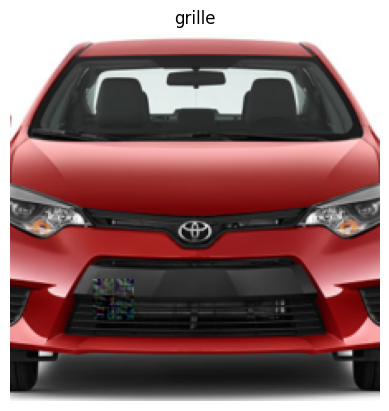

In [22]:
x, y = test_loader.dataset.tensors[0], test_loader.dataset.tensors[1]
x, y = x.to(device), y.to(device)
location = (50, 150, 75, 175)
x_adv, delta = untargeted_l2_pgd_patch(clf, x, y, location, epsilon=20, alpha=1, num_iter=50, lb=0, ub=1)

pred_label_adv = imagenet_labels[clf.predict(x_adv.to(device)).item()]

plt.imshow(x_adv.squeeze().permute(1, 2, 0).cpu().detach())
plt.title(pred_label_adv)
plt.axis('off')
plt.show()



# Exercise 1
* The attack is not working. Why? Debug it and fix it.
* Create the targeted version of this attack.
* Are you satisfied with this version of the attack? Does the patch generalizes on the position it is applied?

### Targeted attack

In [33]:
def targeted_l2_pgd_patch(model, x, yt, location, epsilon=0.3, alpha=0.01, num_iter=40, lb=0, ub=1):
    delta = torch.zeros_like(x, requires_grad=True)
    # Clip the gradient to apply updates only on the patch location
    mask = torch.zeros_like(x)
    x_start, y_start, x_end, y_end = location
    mask[:, :, y_start:y_end, x_start:x_end] = 1.0
    for _ in range(num_iter):
        outputs = model(x + delta)
        loss = torch.nn.CrossEntropyLoss()(outputs, yt)
        loss.backward()

        # Needed to avoid zero division during the normalization
        gradient = delta.grad.data / (delta.grad.data.norm() + 1e-10)
        gradient = gradient * mask # removing all the directions of the gradient except for the mask

        # Gradient descent step
        delta.data = delta - alpha * gradient

        # Project the perturbation to be within the L2 ball of radius epsilon
        if delta.data.norm() > epsilon:
            delta.data = epsilon * delta.data / delta.data.norm()

        # Clip the perturbation to keep the domain constraints
        delta.data = torch.clamp(delta.data, lb - x, ub - x)

        delta.grad.zero_()
    return x.data + delta.data, delta

In [34]:
imagenet_labels[800]

'slot machine'

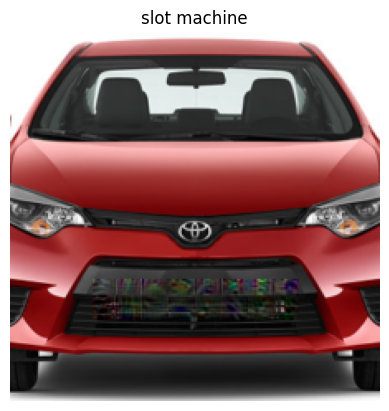

In [44]:
yt = torch.tensor([imagenet_labels.index('slot machine')]) # tensor([800])
x = test_loader.dataset.tensors[0]
x, yt = x.to(device), yt.to(device)
location = (50, 150, 175, 175)
x_adv, delta = targeted_l2_pgd_patch(clf, x, yt, location, epsilon=20, alpha=1, num_iter=50, lb=0, ub=1)

pred_label_adv = imagenet_labels[clf.predict(x_adv.to(device)).item()]

plt.imshow(x_adv.squeeze().permute(1, 2, 0).cpu().detach())
plt.title(pred_label_adv)
plt.axis('off')
plt.show()

In [45]:
def fixed_untargeted_l2_pgd_patch(model, x, y, delta_shape, alpha=0.01, eot_iterations=10, num_iter=40, lb=0, ub=1):
    delta = torch.zeros(delta_shape, requires_grad=True)
    # Clip the gradient to apply updates only on the patch location
    for _ in range(num_iter):
        outputs = torch.zeros(1, len(imagenet_labels)).to(device)
        for i in range(eot_iterations):  # Do multiple random positions for Expectation over Transformation (EoT)
            # random position
            posx = torch.randint(0, x.shape[3] - delta_shape[1] - 1, (1,)).item()
            posy = torch.randint(0, x.shape[2] - delta_shape[2] - 1, (1,)).item()
            patch_width = delta_shape[1]
            patch_height = delta_shape[2]
            patch = torch.zeros_like(x)

            patch[:, :, posy:posy+patch_height, posx:posx+patch_width] = delta.transpose(1,2)
            # Clip the perturbation to keep the domain constraints
            x_adv = torch.clamp(x + patch, lb, ub)
            outputs += model(x_adv)

        outputs = outputs / eot_iterations
        loss = torch.nn.CrossEntropyLoss()(outputs, y)
        loss.backward()

        # Needed to avoid zero division during the normalization
        gradient = delta.grad.data / (delta.grad.data.norm() + 1e-10)

        # Removing the ball, removing epsilon projection

        # Gradient ascent step
        delta.data = delta + alpha * gradient


        delta.grad.zero_()
    x_adv = (x.data + patch.data).clamp(lb,ub)
    return x_adv, delta

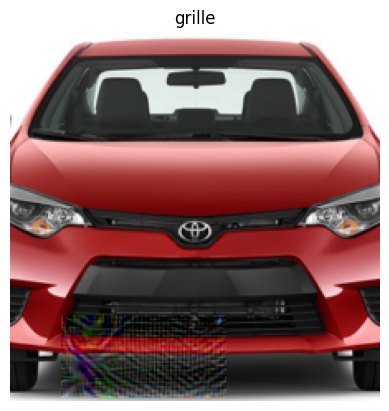

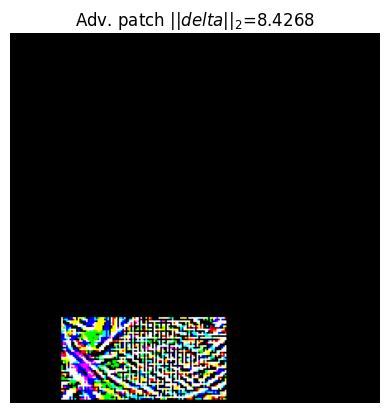

In [7]:
x, y = test_loader.dataset.tensors[0], test_loader.dataset.tensors[1]
x, y = x.to(device), y.to(device)
delta_shape = (3, 100, 50)
x_adv, delta = fixed_untargeted_l2_pgd_patch(clf, x, y, delta_shape, alpha=1, eot_iterations=5, num_iter=50, lb=0, ub=1)

pred_label_adv = imagenet_labels[clf.predict(x_adv.to(device)).item()]

plt.imshow(x_adv.squeeze().permute(1, 2, 0).cpu().detach())
plt.title(pred_label_adv)
plt.axis('off')
plt.show()

magnified = (x_adv - x).squeeze().permute(1, 2, 0).cpu().detach()
plt.imshow(magnified *100)
plt.title(f"Adv. patch $||delta||_2$={magnified.norm():.4f}")
plt.axis('off')
plt.show()



If the attack was successful, we can test the patch in different locations.

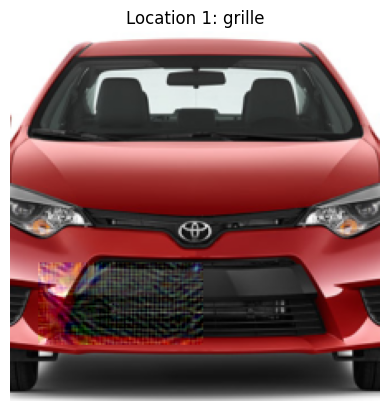

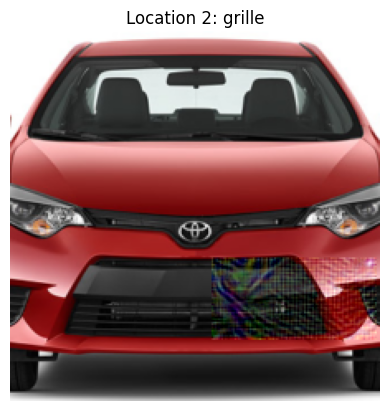

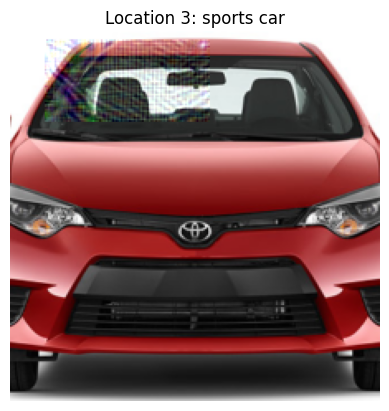

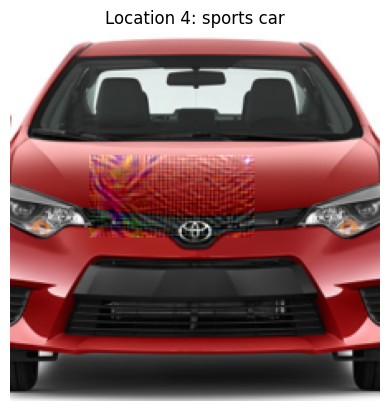

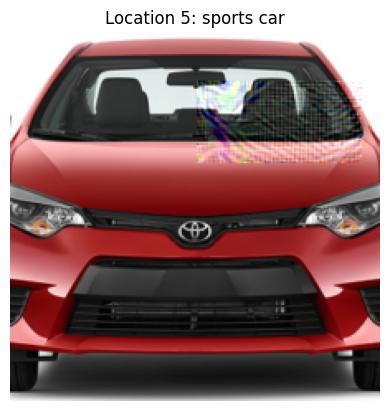

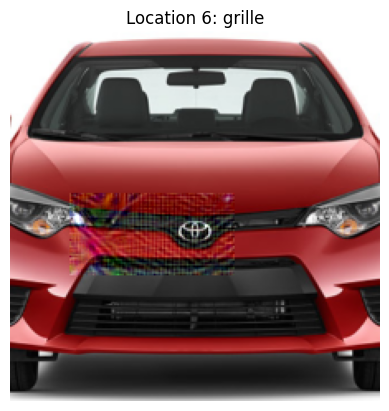

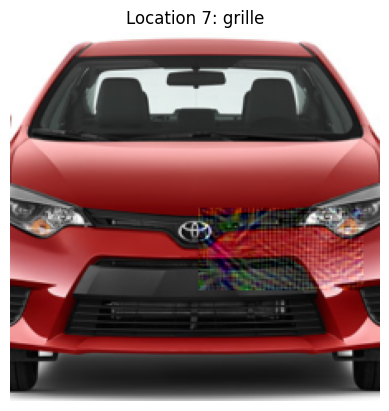

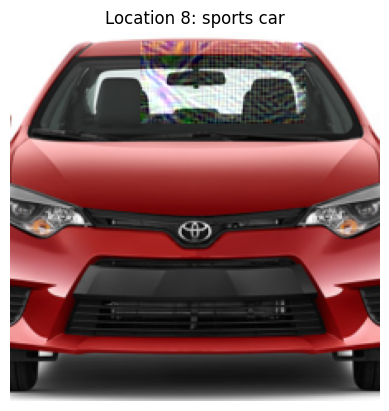

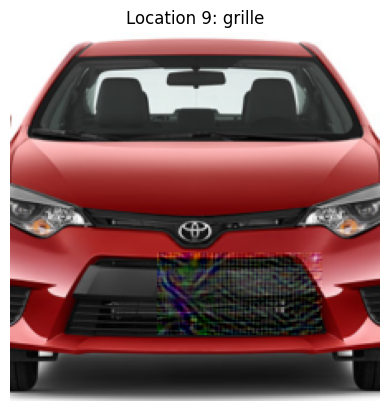

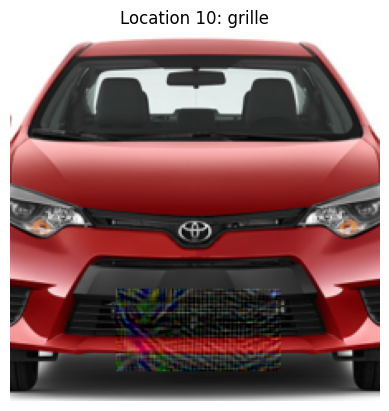

In [8]:

for i in range(10):
    outputs = torch.zeros(1, len(imagenet_labels)).to(device)
    posx = torch.randint(0, x.shape[3] - delta_shape[1] - 1, (1,)).item()
    posy = torch.randint(0, x.shape[2] - delta_shape[2] - 1, (1,)).item()
    patch_width = delta_shape[1]
    patch_height = delta_shape[2]
    patch = torch.zeros_like(x)

    patch[:, :, posy:posy+patch_height, posx:posx+patch_width] = delta.transpose(1,2)
    # Clip the perturbation to keep the domain constraints
    x_adv = (x + patch).clamp(0, 1)
    outputs = clf(x_adv)

    pred_label_adv = imagenet_labels[outputs.argmax(dim=1).item()]

    plt.imshow(x_adv.squeeze().permute(1, 2, 0).cpu().detach())
    plt.title(f"Location {i+1}: {pred_label_adv}")
    plt.axis('off')
    plt.show()